# Extract properties of sequences in parent buckets

In [118]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.ticker as ticker
import sys
from Bio import SeqIO
from pathlib import Path

In [84]:
seqs_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/seqs_extracted/"

In [221]:
summary_extracted_sequences = pd.DataFrame()
for fam in listdir(seqs_dir):
        family_dir=join(seqs_dir, fam)
        fam_name = fam.split(".")[0]
        for f in listdir(family_dir):
            if f.endswith("fasta"):
                # Parse fasta file of extracted sequences 
                fasta_sequences = SeqIO.parse(open(os.path.join(family_dir,f)),'fasta')
                for fasta in fasta_sequences:
                    seq_id = [fasta.id.replace("/","_")]
                    entry = pd.DataFrame({'sequence': seq_id, "name": [f.replace(".PARENTS.fasta","").strip()]})
                    summary_extracted_sequences =  pd.concat([summary_extracted_sequences, entry], ignore_index = True)

In [222]:
summary_extracted_sequences[["family", "bucket_size", "tree"]] = summary_extracted_sequences.name.str.replace("PARENTS.fasta","").str.split(".", expand =True).drop([3,4], axis = 1)
summary_extracted_sequences = summary_extracted_sequences[summary_extracted_sequences.bucket_size == "50"]

/tmp/ipykernel_151386/3394631019.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  summary_extracted_sequences[["family", "bucket_size", "tree"]] = summary_extracted_sequences.name.str.replace("PARENTS.fasta","").str.split(".", expand =True).drop([3,4], axis = 1)


In [223]:
# get af2
# Load AF2 scores
af2 = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/02_summary_af2.csv")
af2_grouped = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/03_summary_af2_grouped.csv")

In [224]:
summary_extracted_sequences_af2 = summary_extracted_sequences.merge(af2, on = ["sequence", "family"])
summary_extracted_sequences_means = summary_extracted_sequences_af2.groupby(['family',"benchmarking_dataset", "name"]).agg({'plddt': ['mean', 'min', 'max']}).reset_index().set_axis(["family", "benchmarking_dataset", "name","plddt_mean_extracted", "plddt_min_extracted", "plddt_max_extracted"], axis=1)
summary_extracted_sequences_means.to_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "03_summary_extracted_sequences.csv"), index = False)

In [225]:
summary_extracted_sequences_af2.head(2)

,sequence,name,family,bucket_size,tree,plddt,benchmarking_dataset
0,D0JGA0_YERPD_1-61,gpdh.50.FAMSA-medoid,gpdh,50,FAMSA-medoid,79.7719,homfam
1,B0FBT8_9BACI_1-37,gpdh.50.FAMSA-medoid,gpdh,50,FAMSA-medoid,74.1260,homfam


# Add % sequences in top bucket 

In [226]:
# Get reference sequences 
def get_seq_names(f, extended = False):
    fasta_sequences = SeqIO.parse(open(f),'fasta')
    seqs = pd.DataFrame()
    
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        entry = pd.DataFrame({'sequence': [fasta.id.replace("/","_")]})
        seqs =  pd.concat([seqs, entry], ignore_index = True)
    seqs["family"] = Path(f).stem
    return(seqs)

In [239]:
homfam_path_ref = "/home/luisasantus/Desktop/crg_cluster/data/structural_regression/homfam/refs"
ref_seqs = pd.DataFrame()
for filename in os.listdir(homfam_path_ref):
    f = os.path.join(homfam_path_ref, filename)
    seq_names = get_seq_names(f)
    seq_names["type"] = "reference"
    ref_seqs = pd.concat([ref_seqs, seq_names])
ref_seqs.to_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "02_summary_reference_sequences.csv"), index = False)

In [240]:
# remove references 
summary_extracted_sequences = summary_extracted_sequences[summary_extracted_sequences.family.str.contains("_ref") == False]
summary_extracted_sequences = summary_extracted_sequences[summary_extracted_sequences.family.str.contains("test") == False]
summary_extracted_sequences = summary_extracted_sequences[summary_extracted_sequences.family.str.contains("_old") == False]

In [241]:
refs_in_bucket = pd.DataFrame(summary_extracted_sequences.merge(ref_seqs, on = ["family","sequence"], how = "outer").groupby(["name","bucket_size"]).count()["type"]).reset_index()
refs_in_bucket

,name,bucket_size,type
0,Acetyltransf.50.FAMSA-medoid,50,4
1,Ald_Xan_dh_2.50.FAMSA-medoid,50,6
2,ChtBD.50.FAMSA-medoid,50,3
3,DEATH.50.FAMSA-medoid,50,3
4,DMRL_synthase.50.FAMSA-medoid,50,3
...,...,...,...
91,tms.50.FAMSA-medoid,50,0
92,toxin.50.FAMSA-medoid,50,3
93,trfl.50.FAMSA-medoid,50,1
94,uce.50.FAMSA-medoid,50,1


In [291]:
refs_in_bucket = pd.DataFrame(summary_extracted_sequences.merge(ref_seqs, on = ["family","sequence"], how = "outer").groupby(["family","bucket_size"]).count()["type"]).reset_index()
refs_in_bucket["bucket_size"] = pd.to_numeric(refs_in_bucket.bucket_size)
refs_in_bucket["perc_refs_extracted"] = refs_in_bucket.type*100/(refs_in_bucket.bucket_size)
refs_in_bucket.to_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "02_summary_reference_in_bucket.csv"), index = False)

# Distribution of # of sequences in parent bucket ? 

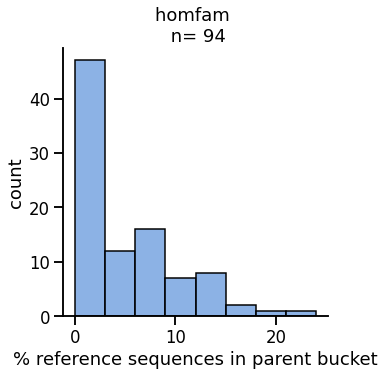

In [252]:
sns.set_context("talk")
ax = sns.displot(refs_in_bucket, x="perc", color = "#69d")
ax.set(xlabel="% reference sequences in parent bucket", ylabel = "count", title = "homfam \n n= "+ str(len(refs_in_bucket.family.unique())))    

# % in parent bucket vs # seqs

In [263]:
#### Load datasets informations (Homfam + extHomfam)
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})
summary_homfam = summary_homfam_exthomfam[summary_homfam_exthomfam.benchmarking_dataset == "homfam"]
summary_homfam.head(2)

,family,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total,benchmarking_dataset
0,rvp,combined,93681,94.288554,22,133,rvp,xlarge,0.006405,homfam
1,zf-CCHH,combined,88345,23.251265,12,35,zf-CCHH,xlarge,0.016979,homfam


[Text(0.5, 0, '% reference sequences in parent bucket'),
 Text(0, 0.5, '# of sequences'),
 Text(0.5, 1.0, 'homfam \n n= 94')]

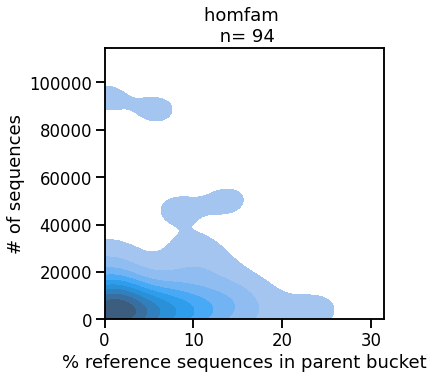

In [289]:
df = summary_homfam.merge(refs_in_bucket, on = ["family"], how = "outer")
sns.set_context("talk")
f, ax = plt.subplots(figsize=(5, 5))

sns.kdeplot(data = df, x="perc", y = "n_sequences", fill = True)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set(xlabel="% reference sequences in parent bucket", ylabel = "# of sequences", title = "homfam \n n= "+ str(len(df.family.unique())))    